This notebook was used to summarize and visualize the results from the abrupntess analysis. The data is first loaded, and global and regional means are computed. The data is visualised using matplotlib.

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

In [2]:
#load data
file1 = "/lustre/backup/WUR/ESG/gohin001/Data/severity/historical_severity.nc"
file2 = "/lustre/backup/WUR/ESG/gohin001/Data/severity/ssp126_severity.nc"
file3 = "/lustre/backup/WUR/ESG/gohin001/Data/severity/ssp370_severity.nc"
file4 = "/lustre/backup/WUR/ESG/gohin001/Data/severity/ssp585_severity.nc"


historical = xr.open_dataset(file1)
ssp126 = xr.open_dataset(file2)
ssp370 = xr.open_dataset(file3)
ssp585 = xr.open_dataset(file4)


In [ ]:
#load drought_flood data to compute masks
file1 = "/lustre/backup/WUR/ESG/gohin001/Data/drought_and_floods/historical_flood_drought_dis>100.nc"
file2 = "/lustre/backup/WUR/ESG/gohin001/Data/drought_and_floods/ssp126_drought_flood_dis>100.nc"
file3 = "/lustre/backup/WUR/ESG/gohin001/Data/drought_and_floods/ssp370_drought_flood_dis>100.nc"
historical_df = xr.open_dataset(file1)
ssp126_df = xr.open_dataset(file2)
ssp370_df = xr.open_dataset(file3)

historical['dis'] = historical_df['dis']
ssp126['dis'] = ssp126_df['dis']
ssp370['dis'] = ssp370_df['dis']

historical['mask'] = historical['dis'].groupby("time.year").mean(dim="time", skipna=True).mean(dim="year") > 100
ssp126['mask'] = ssp126['dis'].groupby("time.year").mean(dim="time", skipna=True).mean(dim="year") > 100
ssp370['mask'] = ssp370['dis'].groupby("time.year").mean(dim="time", skipna=True).mean(dim="year") > 100

In [ ]:
#compute frequency of each transition types
scenarios = {"historical": historical, "ssp126": ssp126, "ssp370": ssp370}
for scenario, array in scenarios.items():
    array["slow_trans_DtoF_count"] = xr.where(array['mask'], (array["transition_times_DtoF"] >= 90).sum(dim="events_sev", skipna=True), np.nan) 
    print(f'nr slow events DtoF {scenario}: {array["slow_trans_DtoF_count"].mean(skipna=True)}')
    array["rapid_trans_DtoF_count"] = xr.where(array['mask'], ((array["transition_times_DtoF"] < 90) & (array["transition_times_DtoF"] > 30)).sum(dim="events_sev", skipna=True), np.nan)
    print(f'nr rapid events DtoF {scenario}: {array["rapid_trans_DtoF_count"].mean()}')
    array["abrupt_trans_DtoF_count"] = xr.where(array['mask'], (array["transition_times_DtoF"] <= 30).sum(dim="events_sev", skipna=True), np.nan) 
    print(f'nr abrupt events DtoF {scenario}: {array["abrupt_trans_DtoF_count"].mean()}')
    array["slow_trans_FtoD_count"] = xr.where(array['mask'], (array["transition_times_FtoD"] >= 90).sum(dim="events_sev", skipna=True), np.nan)
    print(f'nr slow events FtoD {scenario}: {array["slow_trans_FtoD_count"].mean()}')
    array["rapid_trans_FtoD_count"] = xr.where(array['mask'], ((array["transition_times_FtoD"] < 90) & (array["transition_times_FtoD"] > 30)).sum(dim="events_sev", skipna=True), np.nan)
    print(f'nr rapid events FtoD {scenario}: {array["rapid_trans_FtoD_count"].mean()}')
    array["abrupt_trans_FtoD_count"] = xr.where(array['mask'], (array["transition_times_FtoD"] <= 30).sum(dim="events_sev", skipna=True), np.nan)
    print(f'nr abrupt events FtoD {scenario}: {array["abrupt_trans_FtoD_count"].mean()}')

In [ ]:

#create maps for rapid event count

# Define scenarios
scenarios = {
    "Historical": historical, 
    "SSP1-2.6": ssp126, 
    "SSP3-7.0": ssp370
}

# Define event types
event_types = ["DtoF", "FtoD"]

# Define a continuous colormap
cmap = plt.cm.YlOrRd  # Yellow to Red/Orange colormap

# Define boundaries for the colorbar
bounds = np.linspace(0, 140, 10).round(0)# Define value ranges
norm = mcolors.BoundaryNorm(bounds, cmap.N)  # Normalize colors to data range

# Create figure and subplots (rows: scenarios, cols: event types)
fig, axes = plt.subplots(nrows=len(scenarios), ncols=len(event_types),
                         figsize=(15, 10), subplot_kw={"projection": ccrs.PlateCarree()})

# Create a colorbar axis
cbar_ax = fig.add_axes([0.87, 0.3, 0.02, 0.4]) # Adjust the position of the colorbar

# Loop through scenarios and event types
for i, (scenario_name, scenario) in enumerate(scenarios.items()):
    for j, event in enumerate(event_types):
        ax = axes[i, j]
        
        # Extract the correct dataset
        if event == "DtoF":
            data = xr.where(scenario['mask'], scenario['rapid_trans_DtoF_count'], np.nan)
        else:
            data = xr.where(scenario['mask'], scenario['rapid_trans_FtoD_count'], np.nan)
        
        # Add map features with thinner outlines
        ax.add_feature(cfeature.COASTLINE, linewidth=0.5)  # Thin coastline
        ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.4)  # Thin borders
        ax.add_feature(cfeature.LAND, facecolor = "lightgray", edgecolor="black", linewidth=0.3)  # Thin land outline
        ax.add_feature(cfeature.OCEAN, facecolor="lightblue")  # Light gray ocean for better contrast

        # Plot data
        img = data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False, add_labels = False)

        # Remove auto-generated title
        ax.set_title("")  

        # Title for columns
        if i == 0:
            ax.set_title(event, fontsize=12)

        # Label rows
        if j == 0:
            ax.set_ylabel(scenario_name, fontsize=12)

        # Remove gridlines and ticks
        ax.set_xticks([])  # Remove x-axis ticks
        ax.set_yticks([])  # Remove y-axis ticks
        #ax.set_xlabel("")
        #ax.set_ylabel("")
        ax.gridlines(linewidth = 0.3, draw_labels=False)  # Remove gridline labels

plt.subplots_adjust(wspace = -0.2, hspace=0.1)
# Add a single colorbar
fig.colorbar(img, cax=cbar_ax, label="nr of events")
plt.savefig(
    "count_rapid_events.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    pad_inches=0.05  # Minimal external padding
)
plt.show()


In [ ]:
#create maps for abrupt events count
# Define a continuous colormap
cmap = plt.cm.YlOrRd  # Yellow to Red/Orange colormap

# Define boundaries for the colorbar
bounds = np.linspace(0, 40, 10).round(0)# Define value ranges
norm = mcolors.BoundaryNorm(bounds, cmap.N)  # Normalize colors to data range

# Create figure and subplots (rows: scenarios, cols: event types)
fig, axes = plt.subplots(nrows=len(scenarios), ncols=len(event_types),
                         figsize=(15, 10), subplot_kw={"projection": ccrs.PlateCarree()})

# Create a colorbar axis
cbar_ax = fig.add_axes([0.87, 0.3, 0.02, 0.4]) # Adjust the position of the colorbar

# Loop through scenarios and event types
for i, (scenario_name, scenario) in enumerate(scenarios.items()):
    for j, event in enumerate(event_types):
        ax = axes[i, j]
        
        # Extract the correct dataset
        if event == "DtoF":
            data = xr.where(scenario['abrupt_trans_DtoF_count']>1, scenario['abrupt_trans_DtoF_count'], np.nan)
        else:
            data = xr.where(scenario['abrupt_trans_FtoD_count']>1, scenario['abrupt_trans_FtoD_count'], np.nan)
        
        # Add map features with thinner outlines
        ax.add_feature(cfeature.COASTLINE, linewidth=0.5)  
        ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.4)  
        ax.add_feature(cfeature.LAND, facecolor = "lightgray", edgecolor="black", linewidth=0.3)  
        ax.add_feature(cfeature.OCEAN, facecolor="lightblue") 

        # Plot data
        img = data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False, add_labels = False)
    
        # Remove auto-generated title
        ax.set_title("")  

        # Title for columns
        if i == 0:
            ax.set_title(event, fontsize=12)

        # Label rows
        if j == 0:
            ax.set_ylabel(scenario_name, fontsize=12)

        # Remove gridlines and ticks
        ax.set_xticks([])  # Remove x-axis ticks
        ax.set_yticks([])  # Remove y-axis ticks
        #ax.set_xlabel("")
        #ax.set_ylabel("")
        ax.gridlines(linewidth = 0.3, draw_labels=False)  # Remove gridline labels

plt.subplots_adjust(wspace = -0.2, hspace=0.1)
# Add a single colorbar
fig.colorbar(img, cax=cbar_ax, label="nr of events")

plt.savefig(
    "count_abrupt_events.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    pad_inches=0.05  # Minimal external padding
)
plt.show()


/tmp/ipykernel_103911/2887688517.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1.5)
/tmp/ipykernel_103911/2887688517.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


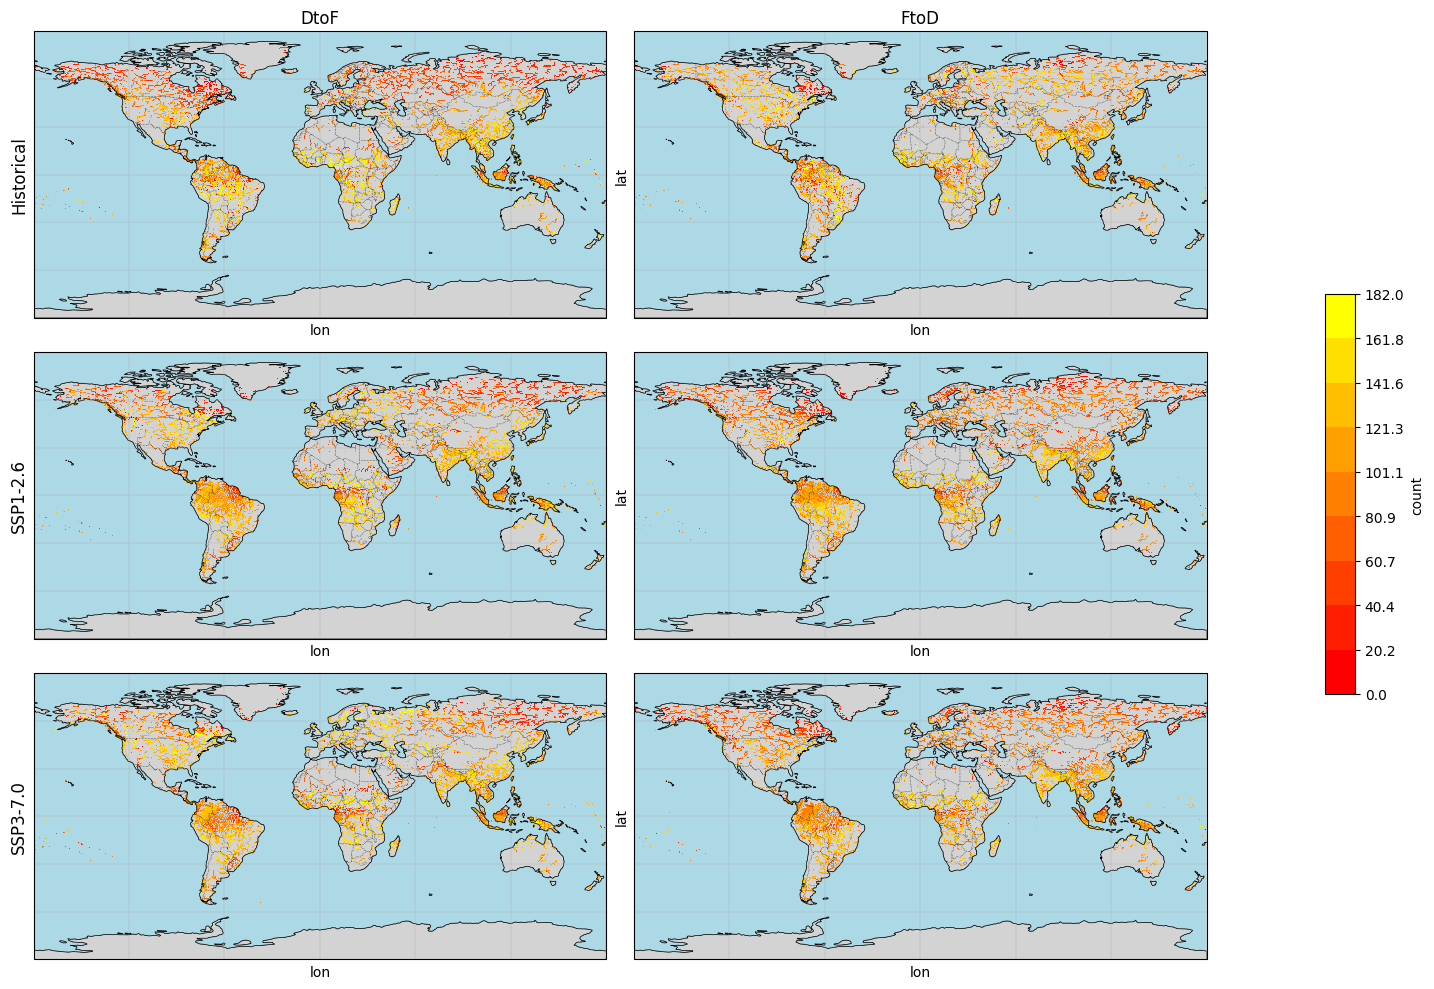

In [11]:
#create maps for historical lag


scenarios = {"historical": historical}
# Define event types
event_types = ["DtoF", "FtoD"]

# Define a continuous colormap
cmap = plt.cm.autumn  # Yellow to Red/Orange colormap

# Define boundaries for the colorbar
bounds = np.linspace(1, 182, 10).round(0)# Define value ranges
norm   = mcolors.BoundaryNorm(bounds, ncolors=cmap.N, clip=False)


# Create figure and subplots (rows: scenarios, cols: event types)
fig, axes = plt.subplots(nrows=len(scenarios), ncols=len(event_types),
                         figsize=(15, 10), subplot_kw={"projection": ccrs.PlateCarree()})
cbar_ax = fig.add_axes([0.2, 0.3, 0.5, 0.02])
for (scenario_name, scenario) in scenarios.items():
    for j, event in enumerate(event_types):
        ax = axes[j]
        
        # Extract the dataset
        if event == "DtoF":
            data = historical['transition_times_DtoF'].mean(dim="events_sev", skipna=True)
        else:
            data = historical['transition_times_FtoD'].mean(dim="events_sev", skipna=True)
        
        # Add map features with thinner outlines
        ax.add_feature(cfeature.COASTLINE, linewidth=0.5)  # Thin coastline
        ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.4)  # Thin borders
        ax.add_feature(cfeature.LAND, facecolor = "lightgray", edgecolor="black", linewidth=0.3)  # Thin land outline
        ax.add_feature(cfeature.OCEAN, facecolor="lightblue")  # Light gray ocean for better contrast
    
        # Plot data
        img = data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False, add_labels=False)
    
        # Remove auto-generated title
        ax.set_title("")  
    
        # Title for columns
        ax.set_title(event, fontsize=12)
    
        # # Label rows
        # if j == 0:
        #     ax.set_ylabel(scenario_name, fontsize=12)
    
        # Remove gridlines and ticks
        ax.set_xticks([])  # Remove x-axis ticks
        ax.set_yticks([])  # Remove y-axis ticks
        #ax.set_xlabel("")
        #ax.set_ylabel("")
        ax.gridlines(linewidth = 0.3, draw_labels=False)  # Remove gridline labels

plt.subplots_adjust(hspace=0.01, wspace=0.5)
cbar = fig.colorbar(img, cax=cbar_ax, ticks = bounds, location="bottom", label="transition time (days)")

plt.tight_layout(pad=1.5)
plt.tight_layout(rect=[0, 0, 0.9, 1]) 
plt.savefig("mean_transition_time_his.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    pad_inches=0.05 
           )
    
plt.show()


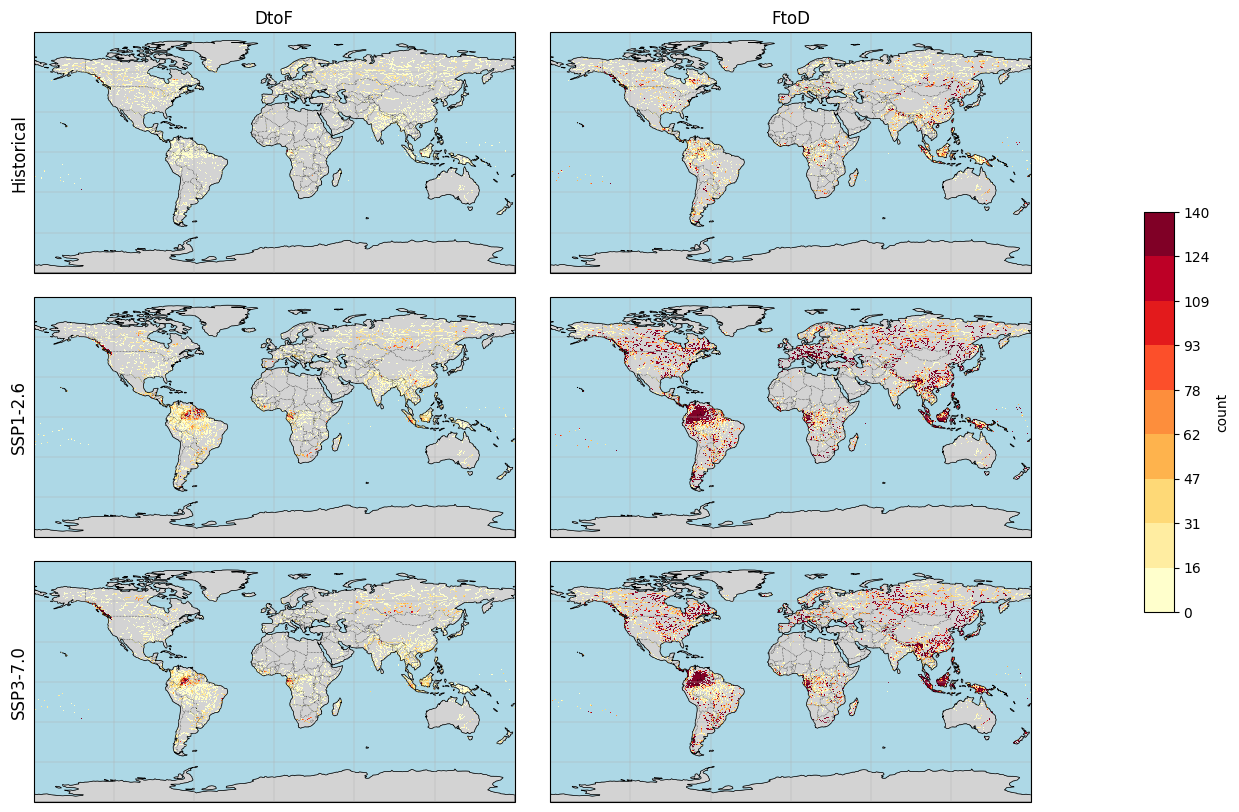

In [5]:
#create maps for lag change in future scenarios

# Define scenarios
scenarios = {"SSP1-2.6": ssp126, "SSP3-7.0": ssp370}

# Define event types
event_types = ["DtoF", "FtoD"]

# Define a continuous colormap
cmap = plt.cm.RdYlBu  # Yellow to Red/Orange colormap

# Define boundaries for the colorbar
bounds = np.linspace(-60, 60, 10).round(0)# Define value ranges
norm = mcolors.BoundaryNorm(bounds, cmap.N)  # Normalize colors to data range

# Create figure and subplots (rows: scenarios, cols: event types)
fig, axes = plt.subplots(nrows=len(scenarios), ncols=len(event_types),
                         figsize=(15, 10), subplot_kw={"projection": ccrs.PlateCarree()})

# Create a colorbar axis
cbar_ax = fig.add_axes([0.2, 0.1, 0.5, 0.02])

# Loop through scenarios and event types
for i, (scenario_name, scenario) in enumerate(scenarios.items()):
    for j, event in enumerate(event_types):
        ax = axes[i, j]
        
        # Extract the correct dataset
        if event == "DtoF":
            data = scenario['transition_times_DtoF'].mean(dim="events_sev") - historical['transition_times_DtoF'].mean(dim="events_sev")
        else:
            data = scenario['transition_times_FtoD'].mean(dim="events_sev") - historical['transition_times_FtoD'].mean(dim="events_sev")
        
        # Add map features with outlines
        ax.add_feature(cfeature.COASTLINE, linewidth=0.5)  
        ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.4)  
        ax.add_feature(cfeature.LAND, facecolor = "lightgray", edgecolor="black", linewidth=0.3) 
        ax.add_feature(cfeature.OCEAN, facecolor="lightblue")  

        # Plot data
        img = data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False, add_labels = False)

        # Remove auto-generated title
        ax.set_title("")  

        # Title for columns
        if i == 0:
            ax.set_title(event, fontsize=12)

        # Label rows
        if j == 0:
            ax.set_ylabel(scenario_name, fontsize=12)

        # Remove gridlines and ticks
        ax.set_xticks([])  # Remove x-axis ticks
        ax.set_yticks([])  # Remove y-axis ticks
        #ax.set_xlabel("")
        #ax.set_ylabel("")
        ax.gridlines(linewidth = 0.3, draw_labels=False)  # Remove gridline labels

plt.subplots_adjust(hspace=-0.65)
# Add a single colorbar
fig.colorbar(img, cax=cbar_ax, location = "bottom", label="change mean transition time (days)")


plt.tight_layout(pad=1.5)
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.savefig(
    "change_mean_transition_time.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    pad_inches=0.05 
)
plt.show()


In [ ]:

#regional analysis of average lags for historical period and future scenarios
regions = {
    "NA":        [historical_NA,  ssp126_NA,  ssp370_NA],
    "SA":        [historical_SA,  ssp126_SA,  ssp370_SA],
    "Europe":    [historical_europe, ssp126_europe, ssp370_europe],
    "SSA":       [historical_SSA, ssp126_SSA, ssp370_SSA],
    "NA_ME":     [historical_NA_ME, ssp126_NA_ME, ssp370_NA_ME],
    "CNA":       [historical_CNA,  ssp126_CNA,  ssp370_CNA],
    "SEA":       [historical_SEA,  ssp126_SEA,  ssp370_SEA],
    "Oce":       [historical_Oce,  ssp126_Oce,  ssp370_Oce]
}

scenario_names = ["historical", "ssp126", "ssp370"]

for region_name, ds_list in regions.items():
    for sc_name, ds in zip(scenario_names, ds_list):
        dtof_mean = ds["transition_times_DtoF"].mean().item()
        ftod_mean = ds["transition_times_FtoD"].mean().item()
        print(f"{region_name:10s} | {sc_name:10s} | DtoF mean: {dtof_mean:7.2f} | FtoD mean: {ftod_mean:7.2f}")


In [ ]:
#computation of global mean lags for DtoF and FtoD
scenarios = {"historical": historical, "ssp126": ssp126, "ssp370": ssp370}
for scenario_name, scenario in scenarios.items():
    print(f"average transition time for DtoF in {scenario_name}: {scenario['transition_times_DtoF'].mean()}")
    print(f"average transition time for FtoD in {scenario_name}: {scenario['transition_times_FtoD'].mean()}")

In [ ]:
### define regions
#North America
historical_NA = historical.sel(lat=slice(75, 15), lon=slice(-170, -50))
ssp126_NA = ssp126.sel(lat=slice(75, 15), lon=slice(-170, -50))
ssp370_NA = ssp126.sel(lat=slice(75, 15), lon=slice(-170, -50))

#South America
historical_SA = historical.sel(lat=slice(15, -60), lon=slice(-85, -30))
ssp126_SA = ssp126.sel(lat=slice(15, -60), lon=slice(-85, -30))
ssp370_SA = ssp370.sel(lat=slice(15, -60), lon=slice(-85, -30))

#Europe
historical_europe = historical.sel(lat=slice(72, 35), lon=slice(-25, 45))
ssp126_europe = ssp126.sel(lat=slice(72, 35), lon=slice(-25, 45))
ssp370_europe = ssp370.sel(lat=slice(72, 35), lon=slice(-25, 45))

#Subsahran Africa
historical_SSA = historical.sel(lat=slice(15, -35), lon=slice(-20, 55))
ssp126_SSA = ssp126.sel(lat=slice(15, -35), lon=slice(-20, 55))
ssp370_SSA = ssp370.sel(lat=slice(15, -35), lon=slice(-20, 55))

#NA/ME
historical_NA_ME = historical.sel(lat=slice(37, 15), lon=slice(-20, 60))
ssp126_NA_ME = ssp126.sel(lat=slice(37, 15), lon=slice(-20, 60))
ssp370_NA_ME = ssp370.sel(lat=slice(37, 15), lon=slice(-20, 60))

#central and northern Asia
historical_CNA = historical.sel(lat=slice(75, 35), lon=slice(40, 140))
ssp126_CNA = ssp126.sel(lat=slice(75, 35), lon=slice(40, 140))
ssp370_CNA = ssp370.sel(lat=slice(75, 35), lon=slice(40, 140))

#South East Asia
historical_SEA = historical.sel(lat=slice(35, -10), lon=slice(65, 135))
ssp126_SEA = ssp126.sel(lat=slice(35, -10), lon=slice(65, 135))
ssp370_SEA = ssp370.sel(lat=slice(35, -10), lon=slice(65, 135))

#Oceania
historical_Oce = historical.sel(lat=slice(0, -50), lon=slice(110, 180))
ssp126_Oce = ssp126.sel(lat=slice(0, -50), lon=slice(110, 180))
ssp370_Oce = ssp370.sel(lat=slice(0, -50), lon=slice(110, 180))                      

In [ ]:
#regional analysis of 
scenario_names = ["historical", "ssp126", "ssp370"]
regions = {
    "NA":        [historical_NA,  ssp126_NA,  ssp370_NA],
    "SA":        [historical_SA,  ssp126_SA,  ssp370_SA],
    "Europe":    [historical_europe, ssp126_europe, ssp370_europe],
    "SSA":       [historical_SSA, ssp126_SSA, ssp370_SSA],
    "NA_ME":     [historical_NA_ME, ssp126_NA_ME, ssp370_NA_ME],
    "CNA":       [historical_CNA,  ssp126_CNA,  ssp370_CNA],
    "SEA":       [historical_SEA,  ssp126_SEA,  ssp370_SEA],
    "Oce":       [historical_Oce,  ssp126_Oce,  ssp370_Oce]
}
for region_name, ds_list in regions.items():
    for sc_name, ds in zip(scenario_names, ds_list):
        dtofmod_mean = ds['slow_trans_DtoF_count'].mean()
        dtofrap_mean = ds['rapid_trans_DtoF_count'].mean()
        dtofabr_mean = ds['abrupt_trans_DtoF_count'].mean()

        ftodmod_mean = ds['slow_trans_FtoD_count'].mean()
        ftodrap_mean = ds['rapid_trans_FtoD_count'].mean()
        ftodabr_mean = ds['abrupt_trans_FtoD_count'].mean()
        
        print(f"{region_name:8s} | {sc_name:10s} | DtoF slow: {dtofmod_mean:3.2f} | DtoF rap : {dtofrap_mean:3.2f}  | DtoF abr: {dtofabr_mean:3.2f} | FtoD mod: {ftodmod_mean:3.2f} | FtoD rap: {ftodrap_mean:3.2f}| FtoD abr: {ftodabr_mean:3.2f}")
